# Fusion Model Development


### Classifers to try:

For explainability:
1. SVM - bad
2. RF
3. KNN - bad
4. XGBoost

Others to try (based on literature):

1. Lasso
2. ElasticNet
3. ??

### Results

Choose binary model based on best AUC score - try putting in the fusion model for now

In [127]:
import json

import numpy as np
import pandas as pd
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

import torch
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, Dataset
from torch import nn
import torch.optim as optim
from torchinfo import summary
from torch.nn import functional as F
import tqdm
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, hamming_loss, multilabel_confusion_matrix
from sklearn.preprocessing import LabelBinarizer
#from torcheval.metrics import MulticlassAUROC

from sklearn import svm
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier 
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, roc_auc_score

#for tuning
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb

import seaborn as sn
import matplotlib.pyplot as plt

In [14]:
#load data
combined_train_df = pd.read_pickle(r'../data/combined_train_df_wembeddings.pkl')
combined_val_df = pd.read_pickle(r'../data/combined_val_df_wembeddings.pkl')
combined_test_df = pd.read_pickle(r'../data/combined_test_df_wembeddings.pkl')

In [15]:
combined_train_df.columns

Index(['index', 'patient_id', 'visit_id', 'study_id', 'temperature',
       'heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity',
       'positive_label_total', 'finding_names', 'radiology_note',
       'discharge_note', 'chief_complaint',
       'major_surgical_or_invasive_procedure', 'history_of_present_illness',
       'past_medical_history', 'family_history', 'atelectasis', 'cardiomegaly',
       'lung_opacity', 'pleural_effusion', 'dataset_type', 'dicom_id',
       'notes_classifications', 'notes_embeddings', 'notes_hidden_embeddings',
       'img_classifications', 'img_embeddings', 'img_densefeatures'],
      dtype='object')

In [16]:
#create aggregated embeddings datasets
#loading datasets
train_x = combined_train_df[['temperature','heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity', 
                             'notes_embeddings', 'notes_hidden_embeddings',
                            'img_embeddings', 'img_densefeatures']]
val_x = combined_val_df[['temperature','heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity', 
                             'notes_embeddings', 'notes_hidden_embeddings',
                            'img_embeddings', 'img_densefeatures']]
test_x = combined_test_df[['temperature','heartrate', 'resprate', 'o2sat', 'sbp', 'dbp', 'pain', 'acuity', 
                             'notes_embeddings', 'notes_hidden_embeddings',
                            'img_embeddings', 'img_densefeatures']]

train_y = combined_train_df['finding_names']
val_y = combined_val_df['finding_names']
test_y = combined_test_df['finding_names']

print("TRAIN: shape of x: {}\nshape of y: {}".format(train_x.shape,train_y.shape))
print("VAL: shape of x: {}\nshape of y: {}".format(val_x.shape,val_y.shape))
print("TEST: shape of x: {}\nshape of y: {}".format(test_x.shape,test_y.shape))

TRAIN: shape of x: (2086, 12)
shape of y: (2086,)
VAL: shape of x: (1924, 12)
shape of y: (1924,)
TEST: shape of x: (1920, 12)
shape of y: (1920,)


In [17]:
def reshape_data(data):
    #gets rid of nested embeddings
    flattened_data = pd.DataFrame()
    
    for col in data.columns:
        data[col] = data[col].apply(np.ravel)

        col_names = []
        for i in range(data[col][0].shape[0]):
            col_name = col + str(i)
            col_names.append(col_name)

        flattened_data[col_names] = pd.DataFrame(data[col].tolist(), index= data.index)
    
    return flattened_data

In [18]:
#reshape data
train_x = reshape_data(train_x)
val_x = reshape_data(val_x)
test_x = reshape_data(test_x)

print("TRAIN: shape of x: {}\nshape of y: {}".format(train_x.shape,train_y.shape))
print("VAL: shape of x: {}\nshape of y: {}".format(val_x.shape,val_y.shape))
print("TEST: shape of x: {}\nshape of y: {}".format(test_x.shape,test_y.shape))

TRAIN: shape of x: (2086, 1755)
shape of y: (2086,)
VAL: shape of x: (1924, 1755)
shape of y: (1924,)
TEST: shape of x: (1920, 1755)
shape of y: (1920,)


In [19]:
train_x.head()

,temperature0,heartrate0,resprate0,o2sat0,sbp0,dbp0,pain0,acuity0,notes_embeddings0,notes_embeddings1,...,img_densefeatures1526,img_densefeatures1527,img_densefeatures1528,img_densefeatures1529,img_densefeatures1530,img_densefeatures1531,img_densefeatures1532,img_densefeatures1533,img_densefeatures1534,img_densefeatures1535
0,98.8,106.0,22.0,96.0,93.0,67.0,0,2.0,-0.267226,0.647106,...,0.604024,0.847728,0.235411,0.730207,0.068122,0.857000,0.055642,0.004653,0.111292,0.237230
1,99.1,80.0,16.0,97.0,162.0,67.0,0,3.0,1.196290,0.296975,...,0.636729,0.731136,0.186779,0.619654,0.222132,0.733983,0.154528,0.018952,0.088321,0.213648
2,97.0,98.0,14.0,100.0,159.0,88.0,2,2.0,1.191423,0.430787,...,0.908274,0.968641,0.257039,0.997114,0.093494,1.075215,0.088319,0.007294,0.080976,0.213116
3,98.6,92.0,20.0,98.0,127.0,70.0,0,2.0,0.443146,1.201157,...,0.980167,1.070965,0.229824,0.877981,0.058277,1.270879,0.053015,0.012560,0.166239,0.218688
4,100.6,110.0,16.0,97.0,166.0,100.0,8,2.0,0.673903,1.203965,...,0.857741,0.895503,0.378214,0.444787,0.078207,0.910277,0.102543,0.052296,0.186534,0.183555


In [29]:
#recode y classes as integers
target_variables_dict = {
    'no_finding': 0,
    'atelectasis': 1,
    'cardiomegaly': 2,
    'lung_opacity': 3,
    'pleural_effusion': 4,
}

def recode_features(data):
    data = data.replace("no_finding", 0)
    data = data.replace("atelectasis", 1)
    data = data.replace("cardiomegaly", 2)
    data = data.replace("lung_opacity", 3)
    data = data.replace("pleural_effusion", 4)
    return data

train_y = recode_features(train_y)
val_y = recode_features(val_y)
test_y = recode_features(test_y)

C:\Users\Carolyn\AppData\Local\Temp\ipykernel_18452\1719064654.py:15: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.replace("pleural_effusion", 4)


In [30]:
#feature scaling
sc = StandardScaler()

train_x = sc.fit_transform(train_x)
val_x = sc.fit_transform(val_x)
test_x = sc.fit_transform(test_x)

In [31]:
#adjust parameters
BATCH_SIZE = 64
LEARNING_RATE = 0.01
EPOCHS = 1000

In [32]:
#defining dataset class
class dataset(Dataset):
  def __init__(self,x,y):
    self.x = torch.tensor(x,dtype=torch.float32)
    self.y = torch.tensor(y,dtype=torch.float32)
    self.length = self.x.shape[0]
 
  def __getitem__(self,idx):
    return self.x[idx],self.y[idx]
  def __len__(self):
    return self.length
      
trainset = dataset(train_x,train_y)

#DataLoader
trainloader = DataLoader(trainset,batch_size=BATCH_SIZE,shuffle=False)

In [33]:
#without Dataloader
X_train = torch.from_numpy(train_x).float()
X_val = torch.from_numpy(val_x).float()

y_train = torch.from_numpy(train_y.to_numpy()).float().reshape(len(train_y), 1)
y_val = torch.from_numpy(val_y.to_numpy()).float().reshape(len(val_y), 1)

## SVM

In [55]:
#Create a svm Classifier
clf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train.ravel())

#Predict the response for test dataset
y_pred = clf.predict(X_val)

In [57]:
# defining parameter range 
param_grid = {'C': [0.1, 1, 10],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf', 'linear']}  
  
grid = GridSearchCV(clf, param_grid, refit = True, verbose = 3) 
  
# fitting the model for grid search 
grid.fit(X_train, y_train.ravel()) 

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.337 total time=   5.2s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.336 total time=   4.9s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.336 total time=   4.9s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.338 total time=   5.6s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.338 total time=   5.3s
[CV 1/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.897 total time=   0.6s
[CV 2/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.911 total time=   0.6s
[CV 3/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.911 total time=   0.5s
[CV 4/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.882 total time=   0.6s
[CV 5/5] END .....C=0.1, gamma=1, kernel=linear;, score=0.904 total time=   0.6s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.337 total time=   4.6s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf

GridSearchCV(estimator=SVC(kernel='linear'),
             param_grid={'C': [0.1, 1, 10],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf', 'linear']},
             verbose=3)

In [58]:
# print best parameter after tuning 
print(grid.best_params_) 
  
# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

{'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
SVC(C=1, gamma=0.001)


In [ ]:
#Create a svm Classifier
clf = svm.SVC(kernel='rbf', gamma = 0.001, C = 1) # Linear Kernel

#Train the model using the training sets
clf.fit(X_train, y_train.ravel())

#Predict the response for test dataset
y_pred = clf.predict(X_val)

In [59]:
# print classification report 
print(classification_report(y_val, grid_predictions)) 

              precision    recall  f1-score   support

         0.0       0.86      0.63      0.73      1376
         1.0       0.12      0.21      0.15       117
         2.0       0.30      0.45      0.36       128
         3.0       0.28      0.46      0.35       219
         4.0       0.22      0.45      0.30        84

    accuracy                           0.56      1924
   macro avg       0.36      0.44      0.38      1924
weighted avg       0.68      0.56      0.61      1924



In [121]:
confusion_matrix(y_val.numpy(), grid_predictions)

array([[867, 137, 102, 190,  80],
       [ 48,  24,  18,  22,   5],
       [ 29,  12,  57,  16,  14],
       [ 55,  22,   9, 100,  33],
       [ 14,   5,   2,  25,  38]], dtype=int64)

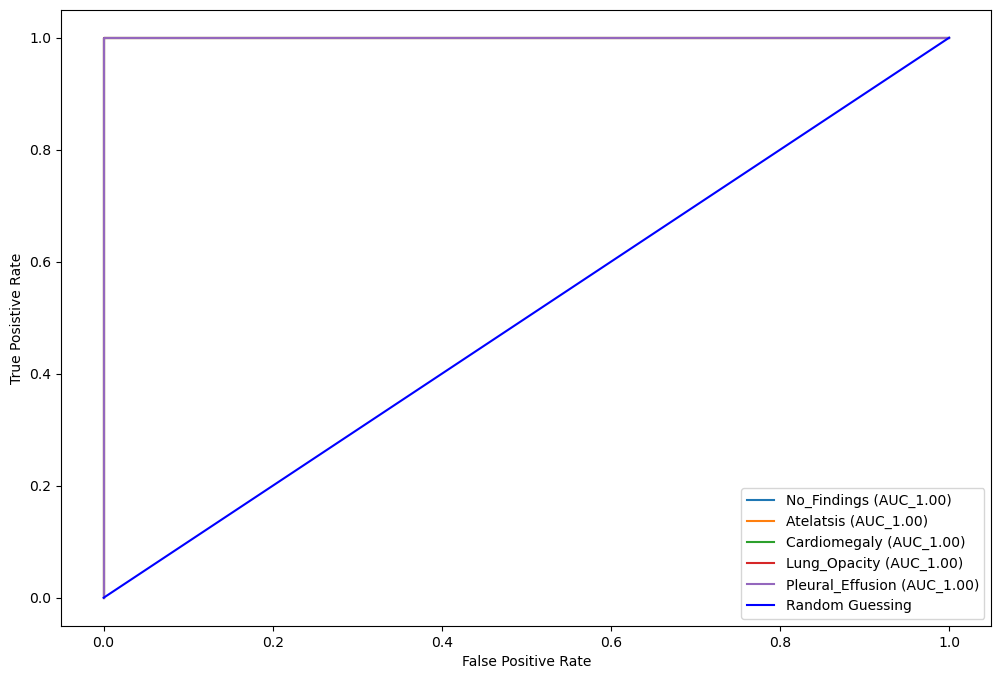

ROC AUC Score---------->
1.000


In [141]:
create_roc_auc_curve_others(clf, X_train, y_train)

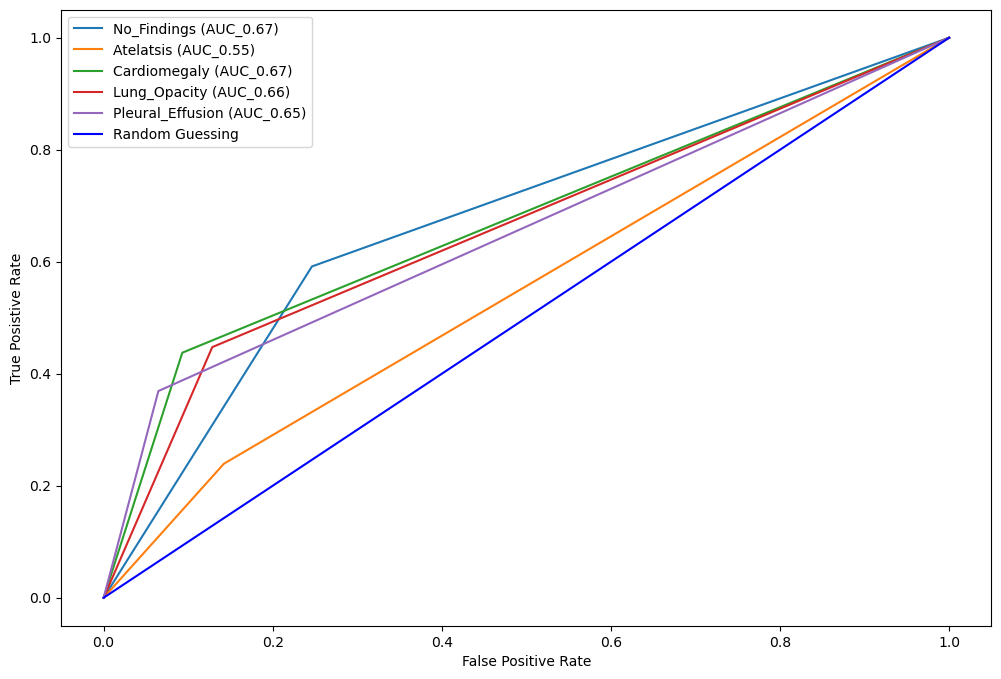

ROC AUC Score---------->
0.641


In [138]:
create_roc_auc_curve_others(clf, X_val, y_val)

# Random Forest

In [131]:
##random search for Random Forest (grid search takes more time)
random_search = RandomizedSearchCV(RandomForestClassifier(random_state=0),
                           {
                              'n_estimators':np.arange(10,100,10),
                              'max_depth': [10, 100, None],
                              'min_samples_leaf': [1, 2],
                              'min_samples_split': [2, 5]
                            },cv=3, scoring="r2",verbose=1,n_jobs=-1, 
                             n_iter=10, random_state = 0
                           )
random_search.fit(X_train,y_train.ravel())

Fitting 3 folds for each of 10 candidates, totalling 30 fits


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(random_state=0),
                   n_jobs=-1,
                   param_distributions={'max_depth': [10, 100, None],
                                        'min_samples_leaf': [1, 2],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   random_state=0, scoring='r2', verbose=1)

In [132]:
#checking the best parameters
print(random_search.best_params_)

{'n_estimators': 20, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_depth': None}


In [133]:
#dictionary of best results
results_df = pd.DataFrame(random_search.cv_results_).sort_values(by = 'rank_test_score', ascending = True)
results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
5,1.300020,0.052900,0.010988,0.002439,20,5,2,None,"{'n_estimators': 20, 'min_samples_split': 5, '...",0.813457,0.758163,0.839779,0.803800,0.034012,1
9,5.973610,0.164820,0.012336,0.000944,60,5,1,None,"{'n_estimators': 60, 'min_samples_split': 5, '...",0.823785,0.751697,0.832672,0.802718,0.036259,2
0,2.381775,0.031811,0.016105,0.003893,40,5,1,None,"{'n_estimators': 40, 'min_samples_split': 5, '...",0.817330,0.748464,0.841717,0.802504,0.039488,3
2,2.441813,0.055699,0.014045,0.000869,40,2,1,None,"{'n_estimators': 40, 'min_samples_split': 2, '...",0.818621,0.751050,0.834611,0.801427,0.036215,4
4,4.943055,0.291062,0.092658,0.016377,70,2,2,10,"{'n_estimators': 70, 'min_samples_split': 2, '...",0.822494,0.731005,0.837195,0.796898,0.046978,5
6,12.712907,0.376418,0.103337,0.026050,90,5,2,None,"{'n_estimators': 90, 'min_samples_split': 5, '...",0.817975,0.721952,0.844301,0.794743,0.052581,6
3,1.798719,0.106750,0.018005,0.003555,30,2,1,10,"{'n_estimators': 30, 'min_samples_split': 2, '...",0.792156,0.767863,0.821690,0.793903,0.022009,7
8,11.144422,2.707150,0.024922,0.009544,80,5,1,10,"{'n_estimators': 80, 'min_samples_split': 5, '...",0.820557,0.717426,0.835903,0.791295,0.052608,8
7,12.502574,1.073238,0.067260,0.031257,80,2,1,10,"{'n_estimators': 80, 'min_samples_split': 2, '...",0.817975,0.716779,0.838487,0.791081,0.053202,9
1,1.205999,0.036360,0.007335,0.000470,20,5,1,10,"{'n_estimators': 20, 'min_samples_split': 5, '...",0.803775,0.719366,0.835257,0.786132,0.048929,10


In [86]:
#run RF with the best parameters
model_rf = RandomForestClassifier(n_estimators = 20, min_samples_split = 5, min_samples_leaf = 2, max_depth = None)

In [88]:
history_rf = model_rf.fit(X_train, y_train.ravel()) 

In [89]:
def get_metrics_others(model, X_train, y_train, X_val, y_val): 
    pred_train = model.predict(X_train)
    pred_val = model.predict(X_val)
    acc_score_train = accuracy_score(y_train, pred_train)
    acc_score_val = accuracy_score(y_val, pred_val)
    rec_score = recall_score(y_val, pred_val,average ="weighted")
    prec_score = precision_score(y_val, pred_val,average ="weighted")
    f1score = f1_score(y_val, pred_val ,average ="weighted")
    print("Training accuracy score---------->")
    print("{0:.3f}".format(acc_score_train*100),"%")
    
    print("Validation accuracy score-------->")
    print("{0:.3f}".format(acc_score_val *100), "%")
    
    print("Recall score---------->")
    print("{0:.3f}".format(rec_score * 100), "%") 
    
    print("Precision score---------->") 
    print("{0:.3f}".format(prec_score * 100), "%")
    
    print("F1 score---------->")
    print("{0:.3f}".format(f1score * 100),"%") 
    return acc_score_train, acc_score_val, rec_score, prec_score, f1score 

In [90]:
rf_acc_train, rf_acc_test, rf_rec, rf_prec, rf_f1 = get_metrics_others(model_rf, X_train, y_train, X_val, y_val)

Training accuracy score---------->
97.795 %
Validation accuracy score-------->
56.549 %
Recall score---------->
56.549 %
Precision score---------->
68.637 %
F1 score---------->
60.702 %


In [98]:
pred_val = model_rf.predict(X_val)
confusion_matrix(y_val, pred_val)

array([[866, 145, 129, 147,  89],
       [ 43,  29,  20,  19,   6],
       [ 31,  12,  64,   7,  14],
       [ 53,  27,  17,  85,  37],
       [ 15,   7,   5,  13,  44]], dtype=int64)

In [94]:
class_label = ['No_Findings', 'Atelatsis', 'Cardiomegaly', 'Lung_Opacity', 'Pleural_Effusion']

def create_confusion_matrix_others(model, X_val, y_val): 
    pred = model.predict(X_val)
    confusion_matrix = confusion_matrix(y_val, pred)
    ax = sns.heatmap(confusion_matrix, annot=True, fmt='.3g', cmap='Blues',
                     cbar=False, xticklabels = ['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc'], yticklabels=['colon_aca', 'colon_n', 'lung_aca', 'lung_n', 'lung_scc'])
    ax.set(xlabel='Predicted Label', ylabel='True Label')
    plt.show()
    return None

In [134]:
def create_roc_auc_curve_others(model, X_val, y_val, average = 'macro'): 
    lw = 2
    fig, c_ax = plt.subplots(1,1, figsize = (12,8))

    pred = model.predict(X_val)
    lb = LabelBinarizer()
    lb.fit(y_val) 
    y_val = lb.transform(y_val) 
    pred = lb.transform(pred) 
    
    for (idx, c_label) in enumerate(class_label): 
        fpr, tpr, thresholds = roc_curve(y_val[:, idx].astype(int), pred[:, idx]) 
        c_ax.plot(fpr, tpr, label = "%s (AUC_%0.2f)" % (c_label, auc(fpr, tpr)))
    c_ax.plot(fpr, fpr, 'b-', label = 'Random Guessing') 
    c_ax.legend()
    c_ax.set_xlabel("False Positive Rate")
    c_ax.set_ylabel("True Posistive Rate") 
    plt.show()
    
    ROCAUCScore = roc_auc_score(y_val, pred, average = average) 
    print('ROC AUC Score---------->')
    print("{0:.3f}".format(ROCAUCScore))
    return None

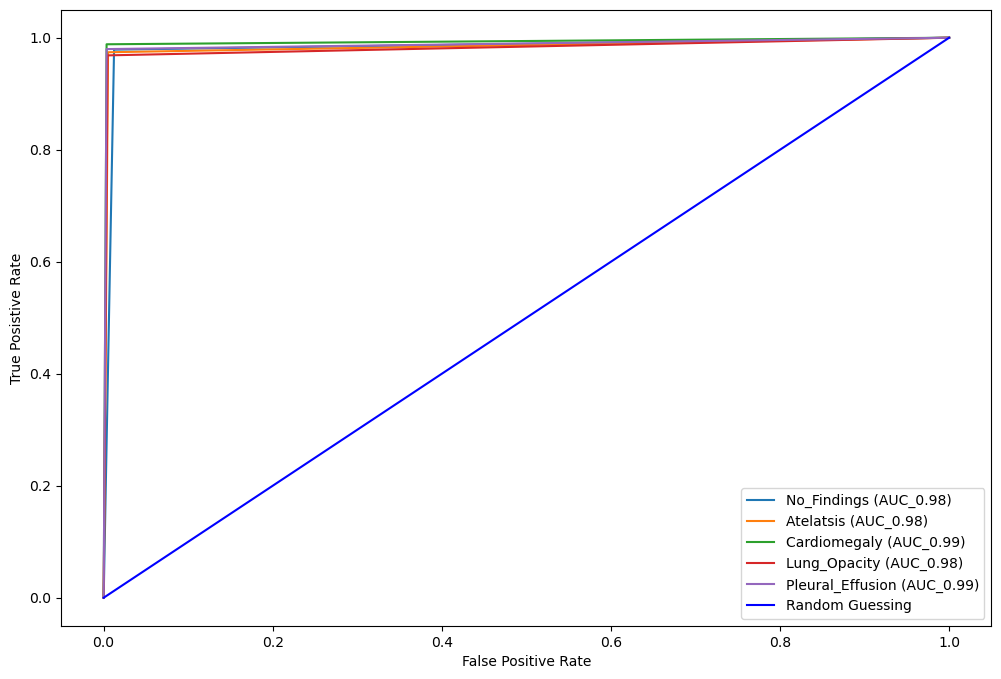

ROC AUC Score---------->
0.986


In [142]:
create_roc_auc_curve_others(model_rf, X_train, y_train)

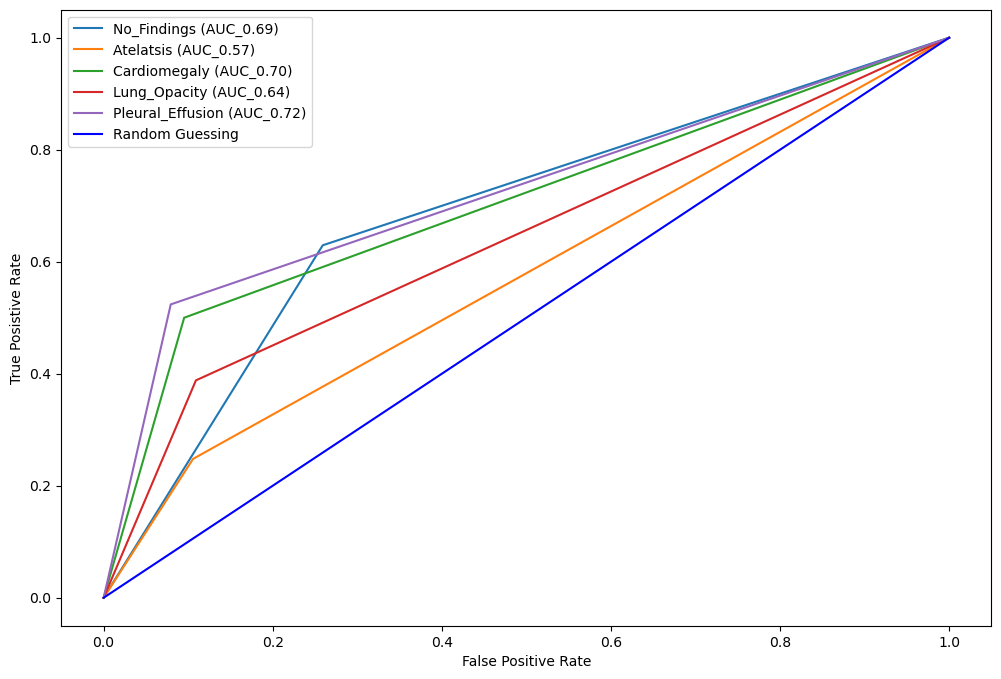

ROC AUC Score---------->
0.664


In [135]:
create_roc_auc_curve_others(model_rf, X_val, y_val)

In [ ]:
model_rf = RF_model_tuned()
history_rf = model_rf.fit(X_train, y_train) 
rf_acc_train, rf_acc_test, rf_rec, rf_prec, rf_f1 = get_metrics_others(model_rf, X_train, y_train, X_val, y_val)
rf_mx = create_confusion_matrix_others(model_rf, X_val, y_val)
rf_roc = create_roc_auc_curve_others(model_rf, X_val, y_val)

In [70]:
# XGBoost (different learning rate)
learning_rate_range = np.arange(0.01, 1, 0.05)
test_XG = [] 
train_XG = []
for lr in learning_rate_range:
    xgb_classifier = xgb.XGBClassifier(eta = lr)
    xgb_classifier.fit(X_train, y_train.ravel())
    train_XG.append(xgb_classifier.score(X_train, y_train.ravel()))
    test_XG.append(xgb_classifier.score(X_val, y_val.ravel()))

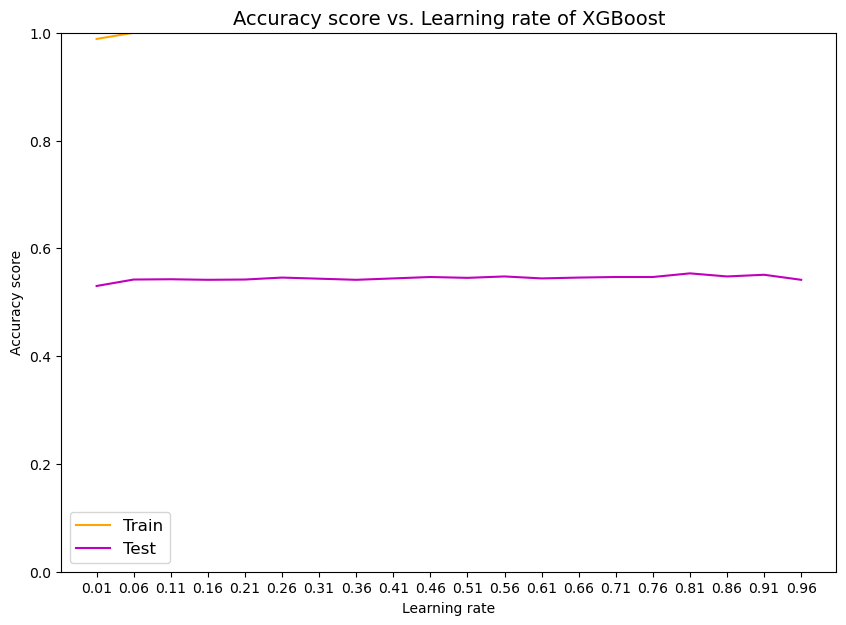

In [71]:
fig = plt.figure(figsize=(10, 7))
plt.plot(learning_rate_range, train_XG, c='orange', label='Train')
plt.plot(learning_rate_range, test_XG, c='m', label='Test')
plt.xlabel('Learning rate')
plt.xticks(learning_rate_range)
plt.ylabel('Accuracy score')
plt.ylim(0, 1)
plt.legend(prop={'size': 12}, loc=3)
plt.title('Accuracy score vs. Learning rate of XGBoost', size=14)
plt.show()

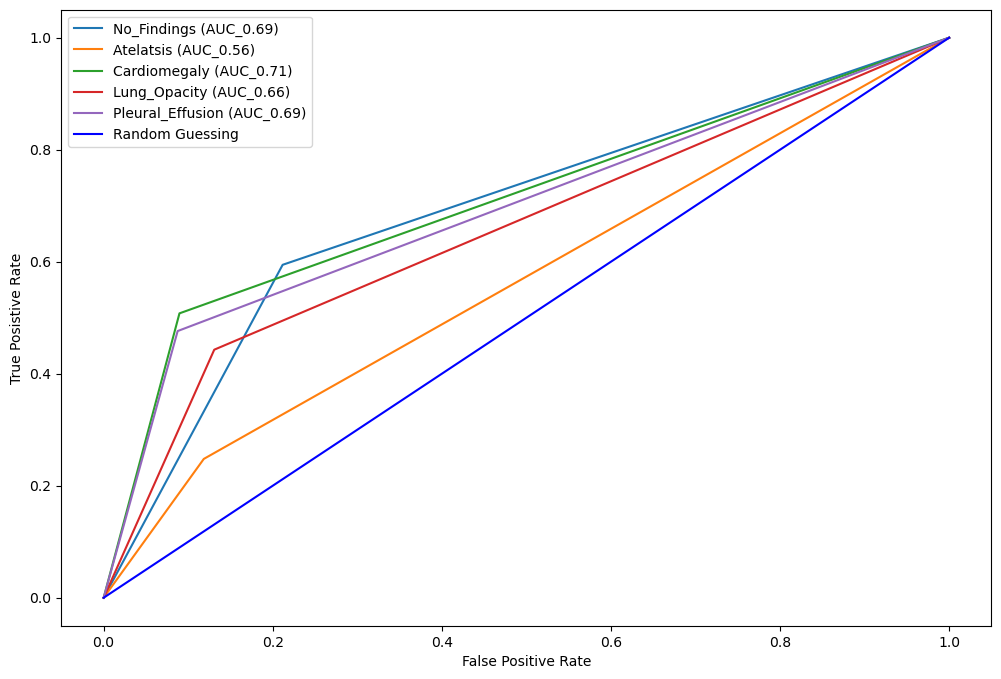

ROC AUC Score---------->
0.663


In [139]:
xgb_classifier = xgb.XGBClassifier(eta = 0.1)
history_xgb = xgb_classifier.fit(X_train, y_train)

create_roc_auc_curve_others(xgb_classifier, X_val, y_val)

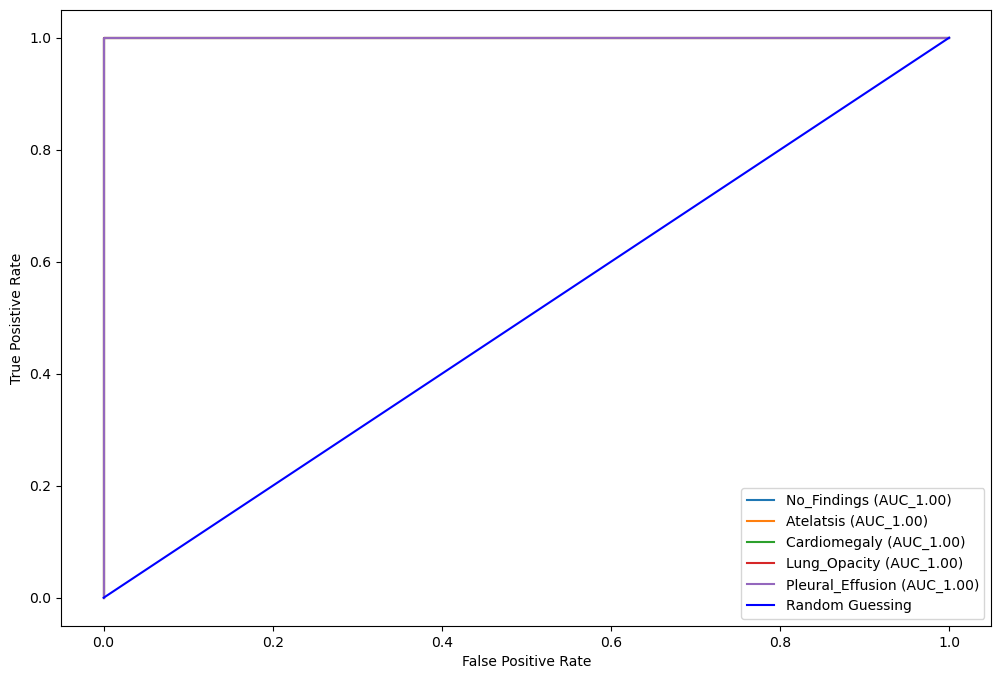

ROC AUC Score---------->
1.000


In [143]:
create_roc_auc_curve_others(xgb_classifier, X_train, y_train)

In [145]:
pred_val_xgb = xgb_classifier.predict(X_val)
confusion_matrix(y_val, pred_val_xgb)

array([[818, 167, 115, 176, 100],
       [ 37,  29,  18,  25,   8],
       [ 22,  14,  65,   8,  19],
       [ 42,  27,  19,  97,  34],
       [ 15,   6,   9,  14,  40]], dtype=int64)

# Summary

RF and XGB best performers - combine training and val, perform cross validation similar to Adam for final models